## Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for shared ride providers. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to competitors depending on the rates.

Given the monthly information for a segment of drivers for 2019 and 2020, the task is to predict whether a driver will be leaving the company or not based on their attributes in the dataset.

* Demographics (city, age, gender etc.)
* Tenure information (joining date, Last Date)
* Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income


## Exploratory Data Analysis

In [958]:
#importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [959]:
# Importing the dataset
df=pd.read_csv("ola_driver_scaler.csv")

In [960]:
# Setting Pandas Option to View All Columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Random sampling and displaying the records
df.sample(frac=1).head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
1355,1355,04/01/20,199,30.0,0.0,C14,0,87902,16/12/16,NaN,1,3,0,3
9044,9044,03/01/20,1335,33.0,0.0,C18,2,157124,13/08/15,NaN,2,3,2758360,4
9453,9453,05/01/19,1403,36.0,0.0,C1,0,64693,29/06/18,17/05/19,2,2,0,1
11739,11739,12/01/19,1743,38.0,0.0,C18,0,45163,08/11/18,NaN,2,2,329980,3
5881,5881,01/01/19,882,29.0,0.0,C13,0,94945,10/12/13,NaN,2,4,0,1


Dropping the "Unnamed:0" column which is typically generated when we convert a pandas DF to csv file.

In [961]:
df=df.drop(["Unnamed: 0"],axis=1)

In [962]:
def remove_outliers(data, features, method='iqr'):
    intial_shape = data.shape
    outliers = pd.DataFrame()
    if method == 'iqr':
            for f in features:
                q1 = data[f].quantile(0.25)
                q3 = data[f].quantile(0.75)
                iqr = q3-q1
                median=data[f].median()
#                 f_outliers = data.loc[(data[f]<q1-1.5*iqr) | (data[f]>q3+1.5*iqr)]
#                 outliers = outliers.append(f_outliers)
#                 data.replace(f_outliers.index,mean,inplace=True)
                data[f] = np.where((data[f]<q1-1.5*iqr) | (data[f]>q3+1.5*iqr),median,data[f])
    elif method == 'z-score':
        for f in features:
            mean = data[f].mean()
            std = data[f].std()
            f_outliers = data.loc[((data[f]-mean)/std<-3) | ((data[f]-mean)/std>3)]
            outliers = outliers.append(f_outliers)
            data.drop(f_outliers.index, inplace=True)
    print(f'{outliers.shape[0]*100/intial_shape[0]}% data detected as outlier.')
    return data, outliers

In [1348]:
def univariate_analysis(data, features, type_of_feature, width = 16, height =9):
    n_features = len(features)
    figsize = (width, height*n_features)
    fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize,constrained_layout=True)
    if n_features == 1:
        ax = [ax]
    if type_of_feature == 'continuous':
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Boxplot for {f}")
            sns.boxplot(y = data[f], ax=ax[i][0])
            ax[i][0].set_ylabel(f)
            sns.histplot(data[f], ax=ax[i][1], kde=True)
            ax[i][1].axvline(data[f].mean(), color='r', linestyle='--', label="Mean")
            ax[i][1].axvline(data[f].median(), color='g', linestyle='-',label="Median")
            ax[i][1].axvline(data[f].mode()[0], linestyle='--',label="Mode")
            ax[i][1].set_title(f"Histplot for {f}")
            ax[i][1].legend()
    elif type_of_feature == 'categorical':
        for i in range(n_features):
            f = features[i]
            counts = df[f].value_counts()
            ax[i][0].set_title(f"Count Plot for {f}")
            counts.plot.bar(ax=ax[i][0],color=sns.color_palette("flare"))
            ax[i][0].set_ylabel("Counts")
            ax[i][0].set_xlabel(f)
            ax[i][1].set_title(f"Pie chart for {f}")
            counts.plot.pie(autopct='%0.0f%%', ax=ax[i][1],colors=sns.color_palette("flare"))
    fig.suptitle(f"Univariate analysis of {type_of_feature} features",fontweight="bold")
    plt.show()

In [1320]:
def bivariate_analysis(data, features, type_of_feature, group_by, width = 16,height = 9):
    n_features = len(features)
    figsize = (width, height*n_features)
    if type_of_feature == 'continuous':
        fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize,constrained_layout=True)
        if n_features == 1:
            ax = [ax]
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Boxplot for {f} by {group_by}")
            sns.violinplot(data=data, y=f, x=group_by, ax=ax[i][0])
            ax[i][0].set_ylabel(f)
            sns.kdeplot(data=data, x=f, hue=group_by, ax=ax[i][1],color=sns.color_palette("flare"))
            ax[i][1].set_title(f"Kdeplot for {f} by {group_by}")
    elif type_of_feature == 'categorical':
        fig, ax = plt.subplots(nrows=n_features, ncols=2, figsize=figsize)
        if n_features == 1:
            ax = [ax]
        for i in range(n_features):
            f = features[i]
            ax[i][0].set_title(f"Count Plot for {f} by {group_by}")
            sns.countplot(data=data, x=f, hue=group_by, ax=ax[i][0])
            ax[i][0].set_ylabel("Counts")
            ax[i][0].set_xlabel(f)
            ax[i][1].set_title(f"Count Plot for {group_by} by {f}")
            sns.countplot(data=data, x=group_by, hue=f, ax=ax[i][1],color=sns.color_palette("flare"))
            ax[i][1].set_ylabel("Counts")
            ax[i][1].set_xlabel(group_by)
    fig.suptitle(f"Bivariate analysis of {type_of_feature} features",fontweight="bold")
    plt.show()

### Dataset description

#### Dataset shape

In [965]:
df.shape

(19104, 13)

*Our dataset captures information about a total of 19104 with each driver record being described by 13 different attributes.*

#### Dataset metadata

In [966]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


### Columns
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

### Converting datetime related fields

In [967]:
#converting time specific columns into datetime variables
df["MMM-YY"]=pd.to_datetime(df["MMM-YY"])
df['Yearofreporting'] = df['MMM-YY'].dt.year 
df['Monthofreporting'] = df['MMM-YY'].dt.month

df["Dateofjoining"]=pd.to_datetime(df["Dateofjoining"])
df['Yearofjoining'] = df['Dateofjoining'].dt.year 
df['Monthofjoining'] = df['Dateofjoining'].dt.month


In [968]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   object        
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
 13  Yearofreporting 

#### Let us pull up the data for one particular driver ID-2563 and make some observations.

In [969]:
df_temp= df[df['Driver_ID']==2563]

In [970]:
df_temp.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Yearofreporting,Monthofreporting,Yearofjoining,Monthofjoining
17477,2019-01-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,484820,3,2019,1,2015,8
17478,2019-02-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,649450,3,2019,2,2015,8
17479,2019-03-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,2016920,3,2019,3,2015,8
17480,2019-04-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,347060,4,2019,4,2015,8
17481,2019-05-01,2563,38.0,0.0,C20,0,53880,2015-08-27,NaN,1,1,687050,4,2019,5,2015,8


### We observe that there are multiple records corresponding to a unique driver ID- 2563

Reported in for work on the first of every month for 5 months (01/01/2019 to 05/01/19).
Since the LastWorkingDate is NaN, it means the driver is still active and not churned yet.
His rating has improved from the third month onwards.
His income has been steady through these 5 months.

Clearly we have to perform some aggregation by the driver ID.

### Non-Graphical Analysis

### Statistical (5-point) summary of the dataset

In [971]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.0,1417.0,2137.0,2788.0
Age,19043.0,34.668435,6.257912e+00,21.0,30.0,34.0,39.0,58.0
Gender,19052.0,0.418749,4.933670e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,19104.0,1.021671,8.001671e-01,0.0,0.0,1.0,2.0,2.0
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.0,60087.0,83969.0,188418.0
Joining Designation,19104.0,1.690536,8.369837e-01,1.0,1.0,1.0,2.0,5.0
Grade,19104.0,2.252670,1.026512e+00,1.0,1.0,2.0,3.0,5.0
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.0,250000.0,699700.0,33747720.0
Quarterly Rating,19104.0,2.008899,1.009832e+00,1.0,1.0,2.0,3.0,4.0
Yearofreporting,19104.0,2019.491834,4.999464e-01,2019.0,2019.0,2019.0,2020.0,2020.0


* We observe difference in counts indicating missing values in a fea columns.
* Mean and Median for Income and Total Business Value significantly differ and indicative of outliers.


#### Duplicate Check

In [972]:
# Returns True of duplicate and series of boolean values
dup_rows = df.duplicated()
dup_rows.sum()

0

##### There are no duplicate records in our dataset

#### Missing values check

In [973]:
#Displaying Columns with Missing Values Percentage of Record Count

print(df.isna().sum()[df.isna().sum()>0].mul(100)/len(df))


Age                 0.319305
Gender              0.272194
LastWorkingDate    91.541039
dtype: float64


* LastWorkingDate has highest number of missing values followed by Age and Gender.

* We observed above that for drivers in active status their Last Working Date value is Null. Once we perform aggregation, we can address this discrepancy.

#### Unique Values check

In [974]:
df.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
Yearofreporting             2
Monthofreporting           12
Yearofjoining               8
Monthofjoining             12
dtype: int64

* Dataset for 24 months for drivers in 29 different cities.
* Our dataset has 19104 entries for 2381 unique drivers, this is inline with our observation above regarding the multiple records for single driver.
* 493 drivers have churned out of the 2381 drivers.
* 5 unique grades and 4 unique quarterly ratings for the drivers.

In [975]:
df['Education_Level'].value_counts()

1    6864
2    6327
0    5913
Name: Education_Level, dtype: int64

* Maximum number of drivers have 12+ education level followed by graduate level.

### Graphical Analysis

In [976]:
 # We separate our feature columns into numerical and categorical sets
numerical_columns = set(df.select_dtypes(['number']).columns)
categorical_columns = list(set(df.columns) - numerical_columns)

In [977]:
numerical_columns

{'Age',
 'Driver_ID',
 'Education_Level',
 'Gender',
 'Grade',
 'Income',
 'Joining Designation',
 'Monthofjoining',
 'Monthofreporting',
 'Quarterly Rating',
 'Total Business Value',
 'Yearofjoining',
 'Yearofreporting'}

#### Analyzing Distributions of Categorical features

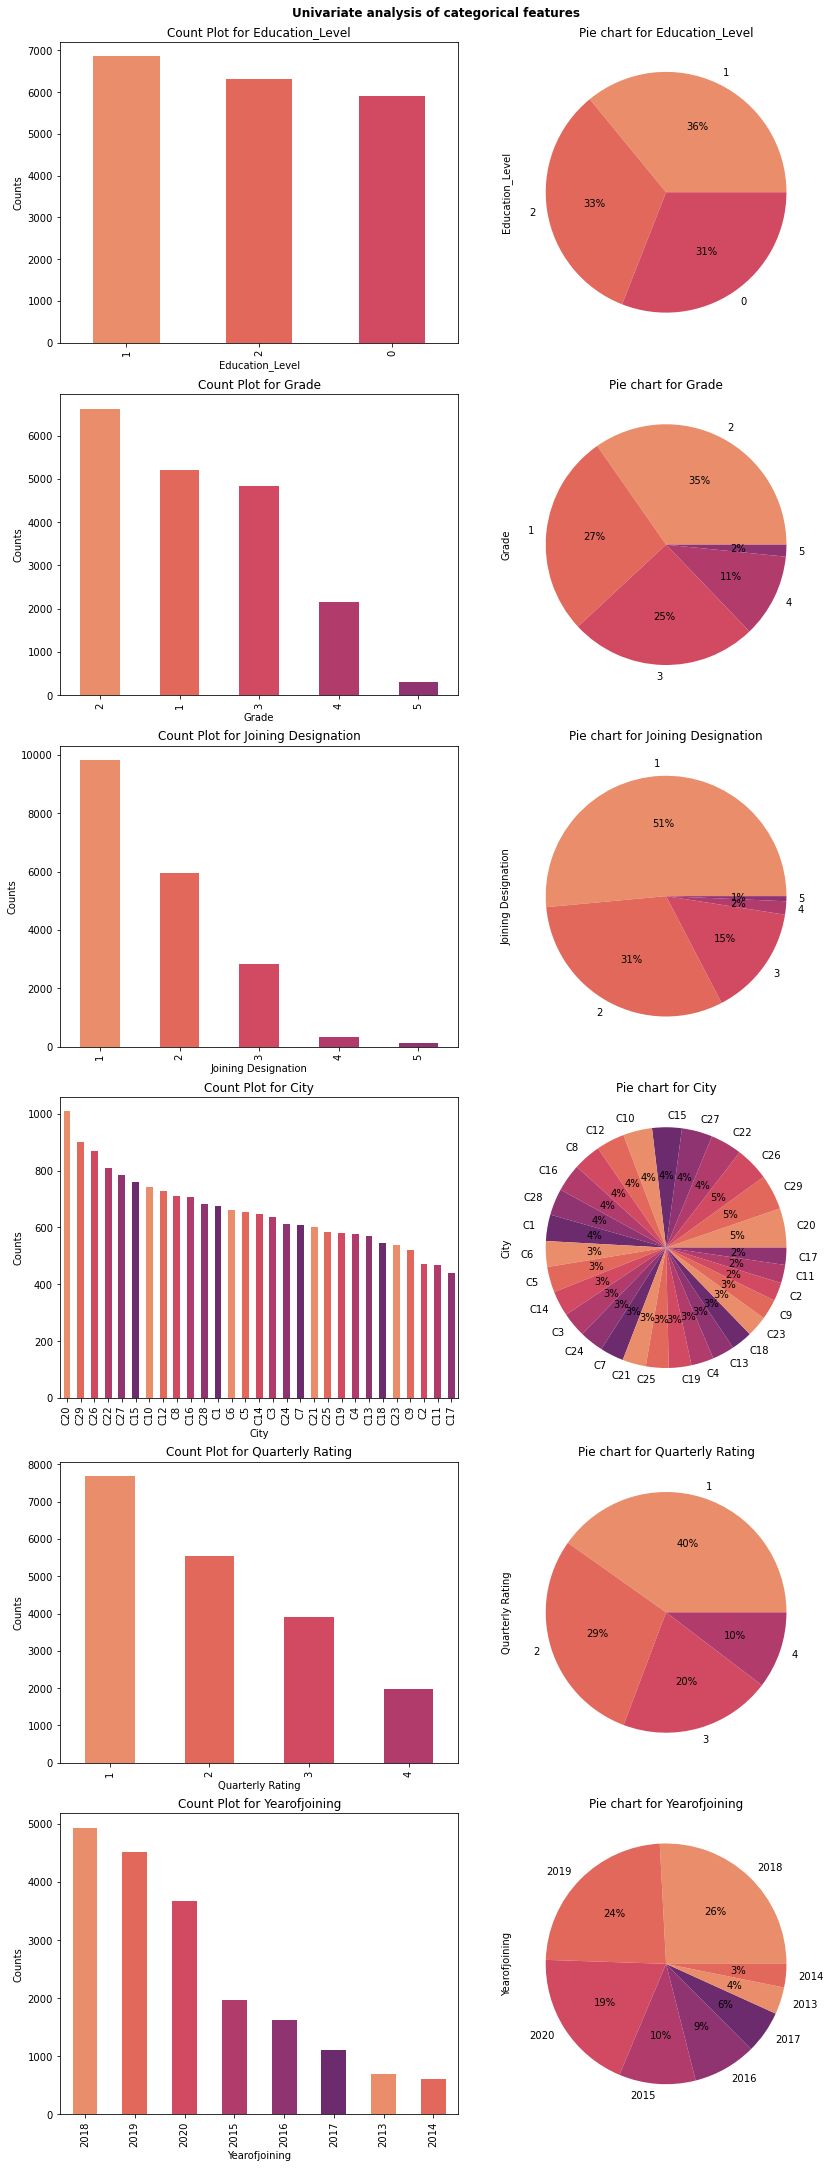

In [1339]:
categorical_cols = ['Education_Level',"Grade",'Joining Designation','City',"Quarterly Rating","Yearofjoining"]

univariate_analysis(data=df, features=categorical_cols,type_of_feature='categorical', width = 12, height = 5)


* City code with C20 has highest no.of employees followed by C29 and C26.
* 41% are women and 59% are men drivers.
* 26% of the drivers in our dataset joined in the year 2018-2019. The number of new joinees reduced in 2020.
* 40% of drivers have a rating of 1 and only 10% have rating of 4.
* Only 3% have a joining designation of 4 or 5. 51% have a designation of 1.
* 35% of drivers fall into grade 2 and only 2% fall into a higher grade. Indicating most of the driver population is relatively recently recruited. A strong indicator of the problem of attrition.
* More or less equal distribution of drivers at each of the three Education levels= 10+,12+ and graduate.There is a possibility to offer subsidized education programs to the drivers in order to cement driver loyalty.

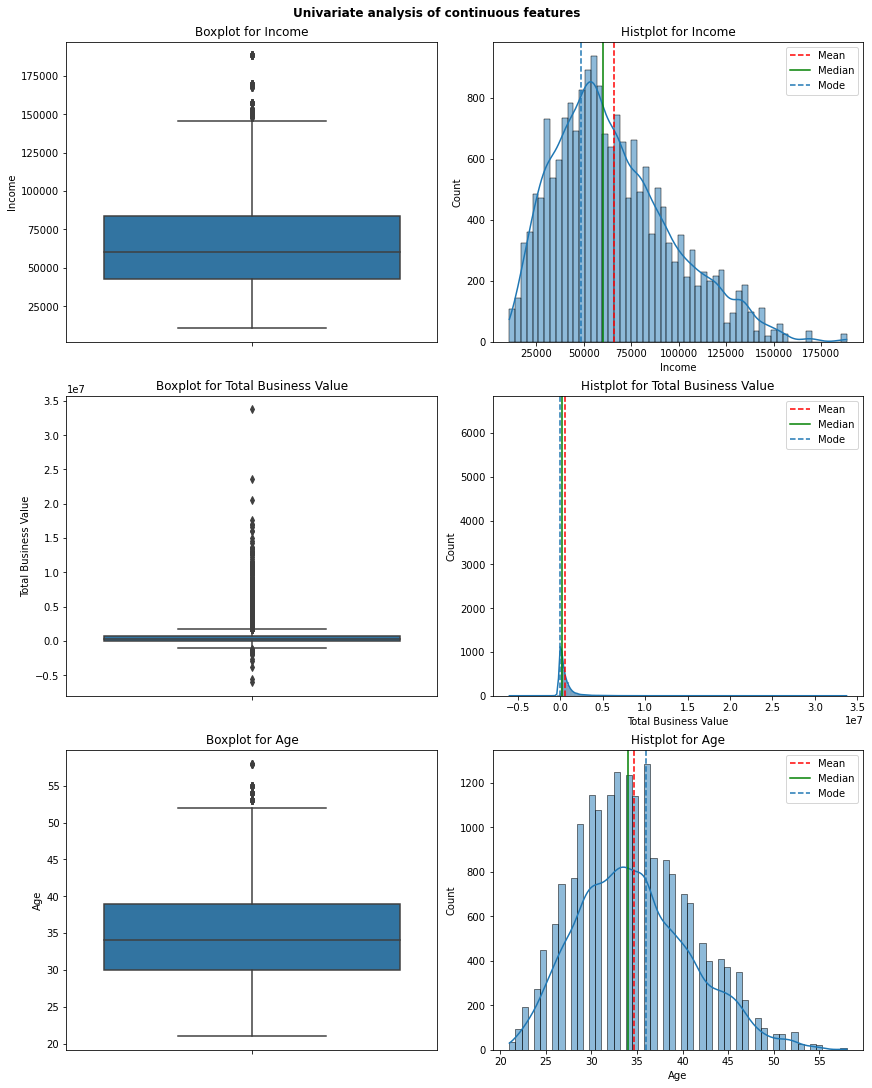

In [1349]:
continuous_cols = ['Income','Total Business Value', "Age"]
univariate_analysis(data=df, features=continuous_cols,type_of_feature='continuous', width = 12, height = 5)

* Driver age Distribution is normal but we observe some outliers.
* The total busines svalue is highly skewed with very high outliers indicating that a small chunk of drivers contribute to the total revenue of the company.
* Income distribution is slightly right skewed with some outliers.

## Feature Engineering

### KNN Imputation for missing values

In [981]:
# Selecting numerical columns
df_nums=df.select_dtypes(np.number)


In [982]:
df_nums.isnull().sum()

Driver_ID                0
Age                     61
Gender                  52
Education_Level          0
Income                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
Yearofreporting          0
Monthofreporting         0
Yearofjoining            0
Monthofjoining           0
dtype: int64

#### KNN imputation removes the column names, hence we are storing the column details, so that we can add them back after missing value imputation.

In [983]:
df_nums.drop(columns='Driver_ID',inplace=True)
columns=df_nums.columns

/Users/navroopgill/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [985]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='uniform', metric='nan_euclidean',)
imputer.fit(df_nums)
# transform the dataset
df_new = imputer.transform(df_nums)

In [986]:
df_new=pd.DataFrame(df_new)

In [987]:
## Adding the columns names 
df_new.columns=columns

In [988]:
df_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
Yearofreporting         0
Monthofreporting        0
Yearofjoining           0
Monthofjoining          0
dtype: int64

Adding the remaining columns (non-numerical) to the dataframe

In [989]:
remaining_columns=list(set(df.columns).difference(set(columns)))
remaining_columns

['City', 'Dateofjoining', 'Driver_ID', 'MMM-YY', 'LastWorkingDate']

In [990]:
data=pd.concat([df[remaining_columns],df_new],axis=1)

In [991]:
data.head()

,City,Dateofjoining,Driver_ID,MMM-YY,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Yearofreporting,Monthofreporting,Yearofjoining,Monthofjoining
0,C23,2018-12-24,1,2019-01-01,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2019.0,1.0,2018.0,12.0
1,C23,2018-12-24,1,2019-02-01,NaN,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2019.0,2.0,2018.0,12.0
2,C23,2018-12-24,1,2019-03-01,03/11/19,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019.0,3.0,2018.0,12.0
3,C7,2020-11-06,2,2020-11-01,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,11.0,2020.0,11.0
4,C7,2020-11-06,2,2020-12-01,NaN,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020.0,12.0,2020.0,11.0


Verifying the concatenation by checking a driver ID sample

In [992]:
data[data['Driver_ID']==2563]

,City,Dateofjoining,Driver_ID,MMM-YY,LastWorkingDate,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Yearofreporting,Monthofreporting,Yearofjoining,Monthofjoining
17477,C20,2015-08-27,2563,2019-01-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,484820.0,3.0,2019.0,1.0,2015.0,8.0
17478,C20,2015-08-27,2563,2019-02-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,649450.0,3.0,2019.0,2.0,2015.0,8.0
17479,C20,2015-08-27,2563,2019-03-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,2016920.0,3.0,2019.0,3.0,2015.0,8.0
17480,C20,2015-08-27,2563,2019-04-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,347060.0,4.0,2019.0,4.0,2015.0,8.0
17481,C20,2015-08-27,2563,2019-05-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,687050.0,4.0,2019.0,5.0,2015.0,8.0
17482,C20,2015-08-27,2563,2019-06-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,514240.0,4.0,2019.0,6.0,2015.0,8.0
17483,C20,2015-08-27,2563,2019-07-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,606980.0,4.0,2019.0,7.0,2015.0,8.0
17484,C20,2015-08-27,2563,2019-08-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,0.0,4.0,2019.0,8.0,2015.0,8.0
17485,C20,2015-08-27,2563,2019-09-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,1451570.0,4.0,2019.0,9.0,2015.0,8.0
17486,C20,2015-08-27,2563,2019-10-01,NaN,38.0,0.0,0.0,53880.0,1.0,1.0,212910.0,2.0,2019.0,10.0,2015.0,8.0


### Aggregate the records

In [993]:
agg_dict = {'Age':'max', 'Gender':'first','City':'first',
 'Education_Level':'last', 'Income':'last',
 'Joining Designation':'last','Grade':'last',
 'Dateofjoining':'last','LastWorkingDate':'last',
 'Total Business Value':'sum','Quarterly Rating':'last',
           "Yearofreporting":"last","Monthofreporting":"last" ,"Yearofjoining": "first","Monthofjoining":"first"}

In [994]:
data_agg=data.groupby(['Driver_ID','MMM-YY']).aggregate(agg_dict)

#### We notice that the reporting date (MMM-YY) needs to be sorted.

In [995]:
data_sort=data_agg.sort_values(by=["Driver_ID",'MMM-YY'], ascending=True).reset_index()

In [996]:
data_sort.columns

Index(['Driver_ID', 'MMM-YY', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Joining Designation', 'Grade', 'Dateofjoining',
       'LastWorkingDate', 'Total Business Value', 'Quarterly Rating',
       'Yearofreporting', 'Monthofreporting', 'Yearofjoining',
       'Monthofjoining'],
      dtype='object')

### Driver Level Aggregation

#### We will create a new dataframe for the driver level aggregation and flags.

In [997]:
df_1=pd.DataFrame()
# adding the unique driver IDs to this new DF.
df_1["Driver_ID"]=data_sort["Driver_ID"].unique()

In [998]:
df_1.head()

,Driver_ID
0,1
1,2
2,4
3,5
4,6


In [999]:
# aggregating various feature values and creating a list that is assigned to the driver IDs in the new dataframe df_1

df_1['Age'] = list(df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
df_1['Gender'] = list(df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
df_1['City'] = list(df.groupby('Driver_ID').agg({'City':'last'})['City'])
df_1['Education_Level'] = list(df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
df_1['Income'] = list(df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
df_1['Joining_Designation'] = list(df.groupby('Driver_ID').agg({'Joining Designation':'last'})["Joining Designation"])
df_1['Grade'] = list(df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
df_1["Total Business Value"] = list(df.groupby('Driver_ID',axis=0).sum("Total Business Value")["Total Business Value"])
df_1['Last_Quarterly_Rating'] = list(df.groupby('Driver_ID').agg({'Quarterly Rating':"last"})["Quarterly Rating"])
df_1['Monthofjoining'] = list(df.groupby('Driver_ID').agg({'Monthofjoining':"first"})["Monthofjoining"])
df_1['Yearofjoining'] = list(df.groupby('Driver_ID').agg({'Yearofjoining':"first"})["Yearofjoining"])
df_1['Yearofreporting'] = list(df.groupby('Driver_ID').agg({'Yearofreporting':"last"})["Yearofreporting"])
df_1['Monthofreporting'] = list(df.groupby('Driver_ID').agg({'Monthofreporting':"last"})["Monthofreporting"])


### Creating binary flags for driver rating increase

#### if the quarterly rating has increased for a driver, we assign the value 1 else 0.

In [1001]:
#Quarterly rating at the beginning
qrf = df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})

#Quarterly rating at the end
qrl = df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

# We create a DF which has the driver IDs and a boolean value which tells if the rating has increased or not.
qr = (qrl['Quarterly Rating']>qrf['Quarterly Rating']).reset_index()


In [1002]:
#the driver ids whose rating has increased

dr_id = qr[qr['Quarterly Rating']==True]['Driver_ID']

In [1003]:
rating_flag = []  # defining an empty list of flags 

for i in df_1['Driver_ID']:
     if i in dr_id.values: 
         rating_flag.append(1)
     else:
         rating_flag.append(0)


### Assigning the flags to the driver IDs 

In [1004]:
df_1['Q_Rating_Inc_Flag'] = rating_flag

### Creating flags for Income increase


In [1006]:
#Income at the beginning
income_first = df.groupby('Driver_ID').agg({'Income':'first'})

# Income at the end

income_last = df.groupby('Driver_ID').agg({'Income':'last'})

#The dataset which has the employee ids and a bollean value which tells if the month

income_diff = (income_last['Income']>income_first['Income']).reset_index()

#the employee ids whose monthly income has increased
dr_id = income_diff[income_diff['Income']==True]['Driver_ID']


In [1008]:
inc = []
for i in df_1['Driver_ID']:
 if i in dr_id.values:
    inc.append(1)
 else:
     inc.append(0)


df_1['Income_Inc_Flag'] = inc

#### Creating the target variable indicating if the driver has left the company

* If a driver has a last working date as non-null we assign a flag value of 1
* If the last working date value is null and does not have a last working date are assigned a flag value of 0.

In [1321]:
# df.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate']

### Statistical summary of the final dataset post feature engineering

In [1011]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2381.0,3.366317e+01,5.983375e+00,21.0,29.0,33.0,37.0,58.0
Gender,2381.0,4.103318e-01,4.919972e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total Business Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Monthofjoining,2381.0,7.357413e+00,3.143143e+00,1.0,5.0,7.0,10.0,12.0
Yearofjoining,2381.0,2.018536e+03,1.609597e+00,2013.0,2018.0,2019.0,2020.0,2020.0
Yearofreporting,2381.0,2.019651e+03,4.766249e-01,2019.0,2019.0,2020.0,2020.0,2020.0


* 2381 unique drivers
* driver median age is 33 years and ranging from 21 yrs to 58 yrs(max).
* Mean monthly income is 59334 and 75% of driver population have their monthly income <= 75,986.
* 50% of the drivers have acquired total busines value of 8,17,680.

### Target Variable

In [1012]:
df_final["Churn"].value_counts()

1    1616
0     765
Name: Churn, dtype: int64

In [1013]:
df_final['Churn'].value_counts(normalize=True)*100

1    67.870643
0    32.129357
Name: Churn, dtype: float64

* Approx 68% of the driver population has left the company.

<AxesSubplot:title={'center':'Driver Attrition'}>

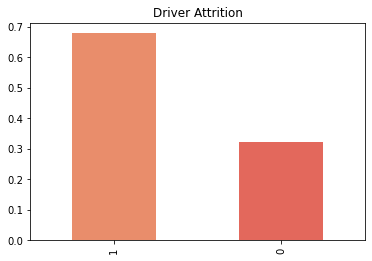

In [1322]:
df_final['Churn'].value_counts(normalize=True).plot.bar(title='Driver Attrition',color=sns.color_palette("flare"))

### Bivariate Analysis of target variable with the features.

### Age - Churn relationship

<AxesSubplot:title={'center':'Age separated by Churn'}, xlabel='Age_Bin'>

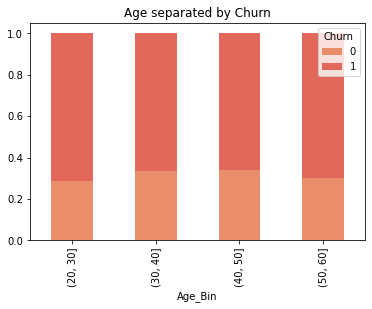

In [1323]:
#Binning the Age into categories
df_final['Age_Bin'] = pd.cut(df_final['Age'],bins=[20,30,40,50,60])

#Age feature with Target
agebin = pd.crosstab(df_final['Age_Bin'],df_final['Churn'])
agebin.div(agebin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Age separated by Churn",color=sns.color_palette("flare"))

* Drivers in the 30-50 years bracket have the highest churn percentage. Lower churn in the 20-30 years bracket.

### City wise Attrition analysis

<Figure size 2160x504 with 0 Axes>

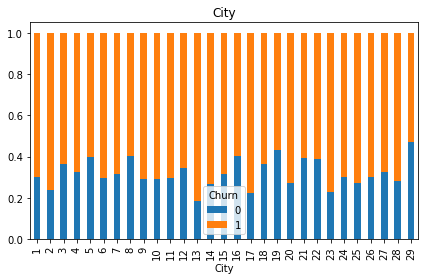

In [1328]:
#City feature with the target
plt.figure(figsize=(30,7))
city = pd.crosstab(df_final['City'],df_final['Churn'])
city.div(city.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="City")
plt.tight_layout()

* Maximum percentage of churn is in C13 city followed by C17 and C2.
* No clear pattern derived from the city information. 

### Income-Churn relationship

<AxesSubplot:title={'center':'Income separated by Churn'}, xlabel='Income_Bin'>

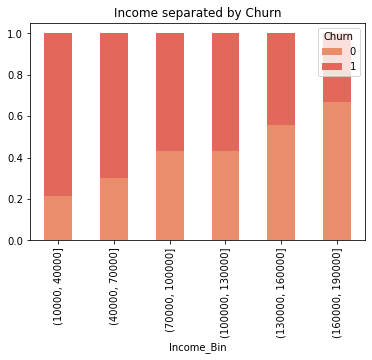

In [1329]:
#Binning the Income into categories
df_final['Income_Bin'] = pd.cut(df_final['Income'],bins=[10000, 40000, 70000, 100000, 130000,160000,190000])

salarybin = pd.crosstab(df_final['Income_Bin'],df_final['Churn'])
salarybin.div(salarybin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Income separated by Churn",color=sns.color_palette("flare"))

* Drivers with lower income are more likely to churn. 
* Churn is same across income brackets of 70K-100K and 100K-130K.
* The employees whose monthly income is in 130K-160K and 160K-190K are less likely to leave the organization


<AxesSubplot:title={'center':'Total Business Value Vs Churn'}, xlabel='TBV_Bin'>

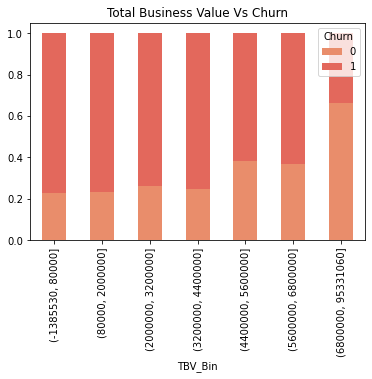

In [1330]:
#Defining the bins and groups
m1 = round(df_final['Total Business Value'].min())
m2 = round(df_final['Total Business Value'].max())
bins = [m1, 80000 , 2000000 , 3200000, 4400000, 5600000, 6800000, m2]
#Binning the Total Business Value into categories
df_final['TBV_Bin'] = pd.cut(df_final['Total Business Value'],bins)
#Total Business Value feature with Target
tbvbin = pd.crosstab(df_final['TBV_Bin'],df_final['Churn'])
tbvbin.div(tbvbin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Total Business Value Vs Churn",color=sns.color_palette("flare"))

* Driver with total business value equal and above 6800,000 are less likely to churn.

In [1055]:
# We are dropping the bin columns we created for the target variable relationship. 
# Also we will drop off the "City" column as it has many unique values that does not have any significant information for our model to learn.
# Driver_ID also needs to be dropped as its a unique identifier.

df_final.drop(["Age_Bin","Income_Bin","TBV_Bin"],axis=1, inplace=True)


In [1056]:
df_final.head()

,Age,Gender,City,Education_Level,Income,Joining_Designation,Grade,Total Business Value,Monthofjoining,Yearofjoining,Yearofreporting,Monthofreporting,Q_Rating_Inc_Flag,Income_Inc_Flag,Churn
0,28.0,0.0,23,2,57387,1,1,1715580,12,2018,2019,3,0,0,1
1,31.0,0.0,7,2,67016,2,2,0,11,2020,2020,12,0,0,0
2,43.0,0.0,13,2,65603,2,2,350000,12,2019,2020,4,0,0,1
3,29.0,0.0,9,0,46368,1,1,120360,1,2019,2019,3,0,0,1
4,31.0,1.0,11,1,78728,3,3,1265000,7,2020,2020,12,1,0,0


In [1057]:
df_final["City"].unique()

array([23,  7, 13,  9, 11,  2, 19, 26, 20, 17, 29, 10, 24, 14,  6, 28,  5,
       18, 27, 15,  8, 25, 21,  1,  4,  3, 16, 22, 12])

In [1058]:
encode_val = {'City': {'C28':28,'C4':4,'C18':18,'C13':13}} 
df_final = df_final.replace(encode_val)


In [1059]:
df_final["City"].unique()

array([23,  7, 13,  9, 11,  2, 19, 26, 20, 17, 29, 10, 24, 14,  6, 28,  5,
       18, 27, 15,  8, 25, 21,  1,  4,  3, 16, 22, 12])

### Correlation Check

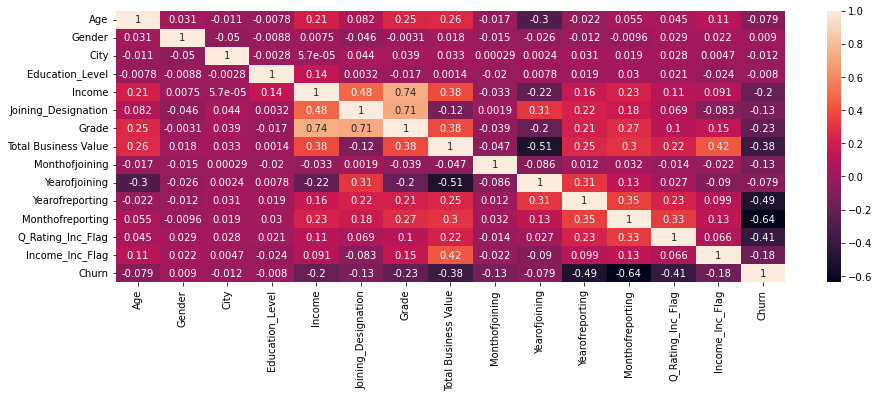

In [1062]:
# Plotting Heat Map to Check for Correlation
plt.figure(figsize=(15,5))
sns.heatmap(df_final.corr(), annot=True) 
plt.show()

* The following are positively correlated
    - Age and Income
    - Joining designation and grade
    - Total business value and grade and income. If the grade is high then the driver has a higher income and the probability of attrition is low.

- Year of joining and Total Business are negatively correlated, indicating the longer a driver has been associated with the company the business acquired by him reduces. This needs to be investigated.
- Quarterly rating and Total Business Value are positively correlated. Meaning if the quarterly rating is high then total business acquired is also high and consequently less chance of driver attrition.
- Negative correlation between attrition and month of reporting. This indicates that drivers who are not regular in reporting every month have a high chance of attrition.

In [1312]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2381 non-null   float64
 1   Gender                2381 non-null   float64
 2   City                  2381 non-null   int64  
 3   Education_Level       2381 non-null   int64  
 4   Income                2381 non-null   int64  
 5   Joining_Designation   2381 non-null   int64  
 6   Grade                 2381 non-null   int64  
 7   Total Business Value  2381 non-null   int64  
 8   Monthofjoining        2381 non-null   int64  
 9   Yearofjoining         2381 non-null   int64  
 10  Yearofreporting       2381 non-null   int64  
 11  Monthofreporting      2381 non-null   int64  
 12  Q_Rating_Inc_Flag     2381 non-null   int64  
 13  Income_Inc_Flag       2381 non-null   int64  
 14  Churn                 2381 non-null   int64  
dtypes: float64(2), int64(

## Data Preprocessing

### Separating the features and target variable

In [1065]:
X=df_final.drop(["Churn"], axis=1)
X.shape

(2381, 14)

In [1066]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2381 non-null   float64
 1   Gender                2381 non-null   float64
 2   City                  2381 non-null   int64  
 3   Education_Level       2381 non-null   int64  
 4   Income                2381 non-null   int64  
 5   Joining_Designation   2381 non-null   int64  
 6   Grade                 2381 non-null   int64  
 7   Total Business Value  2381 non-null   int64  
 8   Monthofjoining        2381 non-null   int64  
 9   Yearofjoining         2381 non-null   int64  
 10  Yearofreporting       2381 non-null   int64  
 11  Monthofreporting      2381 non-null   int64  
 12  Q_Rating_Inc_Flag     2381 non-null   int64  
 13  Income_Inc_Flag       2381 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 260.5 KB


In [1067]:
Y=df_final["Churn"]
Y.shape

(2381,)

In [1068]:
X.shape,Y.shape

((2381, 14), (2381,))

### Date Imbalance Check

In [1069]:
# Printing the percentage of row count per class label
print(df_final.Churn.value_counts(normalize=True).mul(100)) 
# # Printing the absolute row count per class label 
print(df_final.Churn.value_counts())

1    67.870643
0    32.129357
Name: Churn, dtype: float64
1    1616
0     765
Name: Churn, dtype: int64


*We observe the imbalance between the 2 classes, namely- Not Churn (Class 0) and Churn (Class 1). The imbalance ratio Class 0: Class 1 is almost 1:2

*We will perform hyperameter tuning to address this imbalance.*

### Train-Test Split


In [1143]:
## Train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [1144]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 160 to 235
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1523 non-null   float64
 1   Gender                1523 non-null   float64
 2   City                  1523 non-null   int64  
 3   Education_Level       1523 non-null   int64  
 4   Income                1523 non-null   int64  
 5   Joining_Designation   1523 non-null   int64  
 6   Grade                 1523 non-null   int64  
 7   Total Business Value  1523 non-null   int64  
 8   Monthofjoining        1523 non-null   int64  
 9   Yearofjoining         1523 non-null   int64  
 10  Yearofreporting       1523 non-null   int64  
 11  Monthofreporting      1523 non-null   int64  
 12  Q_Rating_Inc_Flag     1523 non-null   int64  
 13  Income_Inc_Flag       1523 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 178.5 KB



#### Target encoding 

In [1145]:
cat_cols=["City"]
from category_encoders import TargetEncoder
enc= TargetEncoder(cols=cat_cols).fit(X_train,Y_train)
X_train= enc.transform(X_train)
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 160 to 235
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1523 non-null   float64
 1   Gender                1523 non-null   float64
 2   City                  1523 non-null   float64
 3   Education_Level       1523 non-null   int64  
 4   Income                1523 non-null   int64  
 5   Joining_Designation   1523 non-null   int64  
 6   Grade                 1523 non-null   int64  
 7   Total Business Value  1523 non-null   int64  
 8   Monthofjoining        1523 non-null   int64  
 9   Yearofjoining         1523 non-null   int64  
 10  Yearofreporting       1523 non-null   int64  
 11  Monthofreporting      1523 non-null   int64  
 12  Q_Rating_Inc_Flag     1523 non-null   int64  
 13  Income_Inc_Flag       1523 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 178.5 KB
None


In [1146]:
#### Target encoding of the validation and test data
X_val= enc_test.transform(X_val,Y_val)
X_test= enc_test.transform(X_test,Y_test)

In [1147]:
X_train.head()

,Age,Gender,City,Education_Level,Income,Joining_Designation,Grade,Total Business Value,Monthofjoining,Yearofjoining,Yearofreporting,Monthofreporting,Q_Rating_Inc_Flag,Income_Inc_Flag
160,34.0,0.0,0.671875,1,20922,2,2,151600,11,2019,2020,3,0,0
1643,37.0,0.0,0.491803,1,67317,1,2,1061950,11,2016,2019,10,0,0
1159,43.0,1.0,0.642857,1,87325,3,3,566440,4,2020,2020,8,0,0
499,30.0,1.0,0.611111,2,70570,1,2,1583300,6,2017,2019,7,0,0
1214,33.0,1.0,0.680851,1,70900,1,1,1741830,9,2018,2019,6,0,0


In [1149]:
X_val.head()

,Age,Gender,City,Education_Level,Income,Joining_Designation,Grade,Total Business Value,Monthofjoining,Yearofjoining,Yearofreporting,Monthofreporting,Q_Rating_Inc_Flag,Income_Inc_Flag
1371,35.0,0.0,0.685535,0,69697,2,2,12641110,10,2018,2020,12,0,0
1844,40.0,0.0,0.685535,1,50801,1,1,13936770,11,2017,2020,12,0,0
1138,32.0,0.0,0.685535,1,70038,2,2,100190,11,2018,2019,3,0,0
1463,46.0,1.0,0.685535,0,44497,1,1,3934690,10,2018,2020,2,0,0
510,39.0,0.0,0.685535,0,86336,3,3,4035480,2,2020,2020,11,0,0


In [1148]:
X_test.head()

,Age,Gender,City,Education_Level,Income,Joining_Designation,Grade,Total Business Value,Monthofjoining,Yearofjoining,Yearofreporting,Monthofreporting,Q_Rating_Inc_Flag,Income_Inc_Flag
1414,36.0,0.0,0.685535,2,59481,2,2,0,11,2019,2020,3,0,0
1075,27.0,1.0,0.685535,2,77369,1,3,1445310,4,2016,2019,5,0,0
1376,29.0,0.0,0.685535,1,56985,2,2,0,11,2020,2020,12,0,0
2002,31.0,0.0,0.685535,2,31124,1,1,0,10,2019,2020,1,0,0
1104,35.0,0.0,0.685535,2,39823,1,1,350000,11,2019,2020,4,0,0


## Building the Model

### Model 1: Baseline model using single Decision Tree 
* Cross Validation and GridSearchCV
* No class balancing

In [1230]:
# We train a simple decision tree using 5-fold cross validation and Grid Search␣
#for best hyper-param selection
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree
from sklearn.model_selection import GridSearchCV
params = {
"max_depth" : [3, 5, 7,9],"max_leaf_nodes" : [15, 20, 25,30]
}
model1 = DTC()
clf = GridSearchCV(model1, params, scoring = "f1", cv=5) # as the data is imbalanced, we will use f1 score
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_leaf_nodes': [15, 20, 25, 30]},
             scoring='f1')

In [1231]:
res = clf.cv_results_
for i in range(len(res["params"])):
    print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 3, 'max_leaf_nodes': 15} Mean_score: 0.970089484601768 Rank: 2
Parameters:{'max_depth': 3, 'max_leaf_nodes': 20} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 3, 'max_leaf_nodes': 25} Mean_score: 0.970089484601768 Rank: 2
Parameters:{'max_depth': 3, 'max_leaf_nodes': 30} Mean_score: 0.9700842127187708 Rank: 4
Parameters:{'max_depth': 5, 'max_leaf_nodes': 15} Mean_score: 0.9656172399098946 Rank: 8
Parameters:{'max_depth': 5, 'max_leaf_nodes': 20} Mean_score: 0.9656171543489513 Rank: 9
Parameters:{'max_depth': 5, 'max_leaf_nodes': 25} Mean_score: 0.9661282587537144 Rank: 7
Parameters:{'max_depth': 5, 'max_leaf_nodes': 30} Mean_score: 0.9666417344188988 Rank: 6
Parameters:{'max_depth': 7, 'max_leaf_nodes': 15} Mean_score: 0.9652888034978601 Rank: 10
Parameters:{'max_depth': 7, 'max_leaf_nodes': 20} Mean_score: 0.9641697163175266 Rank: 11
Parameters:{'max_depth': 7, 'max_leaf_nodes': 25} Mean_score: 0.9636420528691744 Rank: 13
Parameters:{'max_dep

In [1232]:
print(clf.best_estimator_)
def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(clf)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=20)
Best parameters are : {'max_depth': 3, 'max_leaf_nodes': 20}
The score is : 0.9706005034455879


In [1199]:
## Training the MODEL using the best hyperparameters
model1 = clf.best_estimator_
mmodel1 = clf.best_estimator_
model1.fit(X_train, Y_train)odel1.fit(X_train, Y_train)

Model Performance Metrics


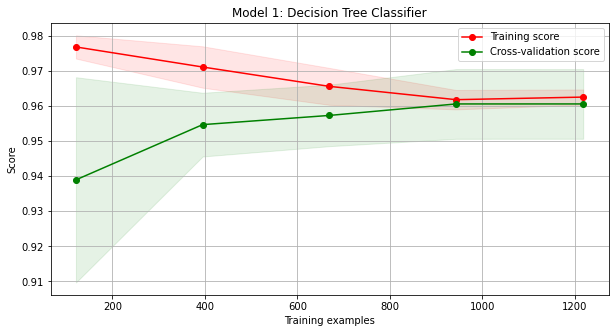

                          precision    recall  f1-score   support

Not leaving the company        0.92      0.95      0.93       150
     Leaving the company       0.98      0.96      0.97       327

                accuracy                           0.96       477
               macro avg       0.95      0.95      0.95       477
            weighted avg       0.96      0.96      0.96       477

Test Accuracy : 95.80712788259959%
recall_score : 96.3302752293578%
precision_score : 97.52321981424149%
f1_score : 96.92307692307692%
[[142   8]
 [ 12 315]]
Model 1: Decision Tree Classifier Sensitivity:0.96
Model 1: Decision Tree Classifier Specificity:0.95


In [1249]:
print("Model Performance Metrics")

plot_learning_curve(model1, X_train, Y_train, "Model 1: Decision Tree Classifier")
Y_pred_model1 = model1.predict(X_test)
print(f"{classification_report(Y_test, Y_pred_model1, target_names=['Not leaving the company ','Leaving the company'])}")
# more data could help as CV-score is improving as datset size increases.


print(f"Test Accuracy : {accuracy_score(Y_test, Y_pred_model1)*100}%")
print(f"recall_score : {recall_score(Y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(Y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(Y_test, Y_pred)*100}%")

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

confusion = confusion_matrix(Y_test, Y_pred_model1)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
print(f"Model 1: Decision Tree Classifier Sensitivity:{np.round(TP/(TP+FN),2)}")

# Calculate the specificity
print(f"Model 1: Decision Tree Classifier Specificity:{np.round(TN/(TN+FP),2)}")


AUC SCORE :0.9649847094801224


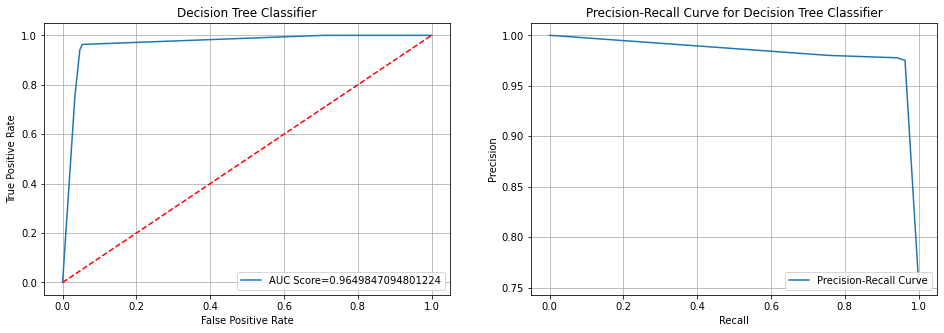

In [1270]:

# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)

#Create ROC curve and PR curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("Decision Tree Classifier")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(Y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for Decision Tree Classifier")
plt.show()



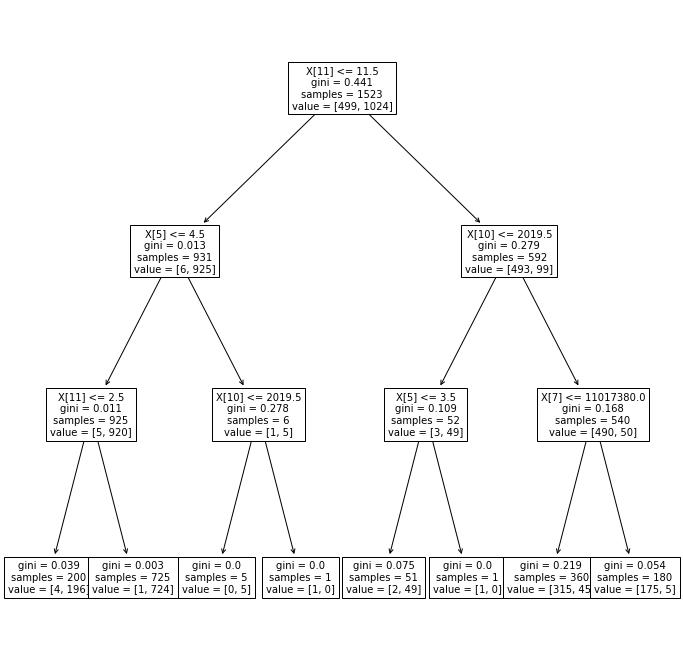

In [1213]:
# plot the decision tree
from sklearn import tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(model1, fontsize=10)
plt.show()

### Feature Importance

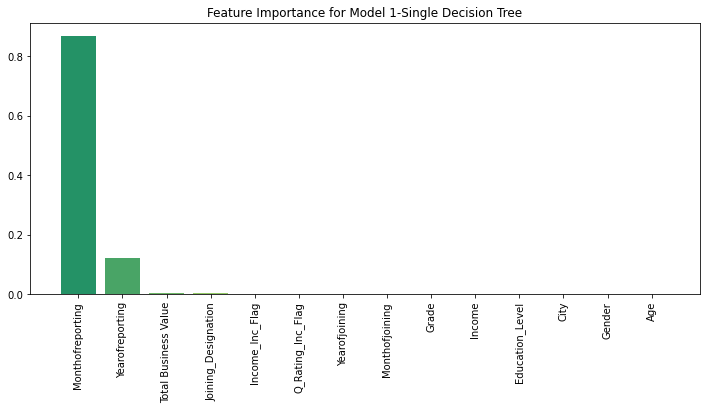

In [1214]:
importances = model1.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(12, 5)) # Create plot
plt.title("Feature Importance for Model 1-Single Decision Tree") # Create plot title
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("summer")) # Add bars
plt.xticks(range(X_test.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() 

### Observations from Model 1- Decision Tree Classifier:

* Best Hyperparameters are max_depth=3, max_leaf_nodes=15.
* The f1 score for predicting leaving the company is 0.97
* The recall score for predicting leaving the company is 0.96
* The precision score for predicting leaving the company is 0.98
* The AUC score for predicting leaving the company is 0.96
* Model Sensitivity:0.95
* Model Specificity:0.96
* The most important features according to model 1: Month of Reporting and Year of reporting, followed by Total Business Value and Joining Designation. Drivers who are not consistently logging into the system, are likely to attrition.

### Model 2:  Random Forest Classifier


* Random Forests combines the prediction of mutliple deep decision trees using the Bootstrapped Aggregation (bagging) technique.
* Random forests are trivially parallelizable.
* Runtime complexity is higher O(depth)

In this classifier model we will use -
* Hyperparameter Tuning for max_depth and number of trees (estimators) using GridSearchCV.
* F1 score as the metric as the data is imbalanced.
* Balance the class weights-using"Balanced" mode. This uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [1240]:
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix


param = {'max_depth':[2,3,4,5], 'n_estimators':[50,100,150,200]}
random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=5,scoring='f1')
c.fit(X_train, Y_train)


def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(c)


Best parameters are : {'max_depth': 3, 'n_estimators': 50}
The score is : 0.9706005034455879


In [1243]:
res = c.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 2, 'n_estimators': 50} Mean_score: 0.964375307463115 Rank: 16
Parameters:{'max_depth': 2, 'n_estimators': 100} Mean_score: 0.9695731938749509 Rank: 14
Parameters:{'max_depth': 2, 'n_estimators': 150} Mean_score: 0.9680218119556316 Rank: 15
Parameters:{'max_depth': 2, 'n_estimators': 200} Mean_score: 0.9695780404320595 Rank: 13
Parameters:{'max_depth': 3, 'n_estimators': 50} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 3, 'n_estimators': 100} Mean_score: 0.9700918248932127 Rank: 11
Parameters:{'max_depth': 3, 'n_estimators': 150} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 3, 'n_estimators': 200} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 4, 'n_estimators': 50} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 4, 'n_estimators': 100} Mean_score: 0.9700867189844349 Rank: 12
Parameters:{'max_depth': 4, 'n_estimators': 150} Mean_score: 0.9706005034455879 Rank: 1
Parameters:{'max_depth': 4, 'n

In [1242]:
print(c.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=50)


### Training on Best Hyperparameters

In [1246]:
random_forest=c.best_estimator_
random_forest.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=50)

 Model 2: Random Forest Classifier: Performance Report


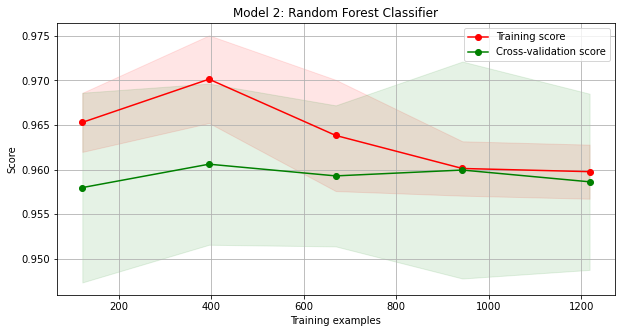

                                   precision    recall  f1-score   support

Not leaving the company (Churn:0)       0.92      0.95      0.93       150
    Leaving the company (Churn:1)       0.98      0.96      0.97       327

                         accuracy                           0.96       477
                        macro avg       0.95      0.95      0.95       477
                     weighted avg       0.96      0.96      0.96       477

Test Accuracy : 95.80712788259959%
recall_score : 96.3302752293578%
precision_score : 97.52321981424149%
f1_score : 96.92307692307692%
[[142   8]
 [ 12 315]]
Model 2 Sensitivity: 0.96
Model 2 Specificity: 0.95


In [1248]:
print(" Model 2: Random Forest Classifier: Performance Report")

Y_pred = random_forest.predict(X_test)
plot_learning_curve(random_forest, X_train, Y_train, "Model 2: Random Forest Classifier")
print(f"{classification_report(Y_test, Y_pred, target_names=['Not leaving the company (Churn:0)','Leaving the company (Churn:1)'])}")



print(f"Test Accuracy : {accuracy_score(Y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(Y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(Y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(Y_test, Y_pred)*100}%")

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

confusion = confusion_matrix(Y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Calculate the sensitivity

print(f"Model 2 Sensitivity: {np.round((TP/(TP+FN)),2)}")
# Calculate the specificity

print(f"Model 2 Specificity: {np.round((TN/(TN+FP)),2)}")



AUC SCORE :0.9741896024464832


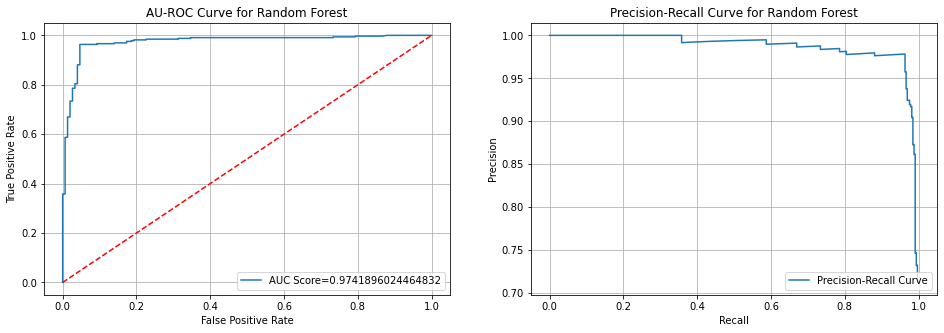

In [1269]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = random_forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
#Create ROC curve and PR curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AU-ROC Curve for Random Forest")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(Y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for Random Forest")
plt.show()


### Feature Importance

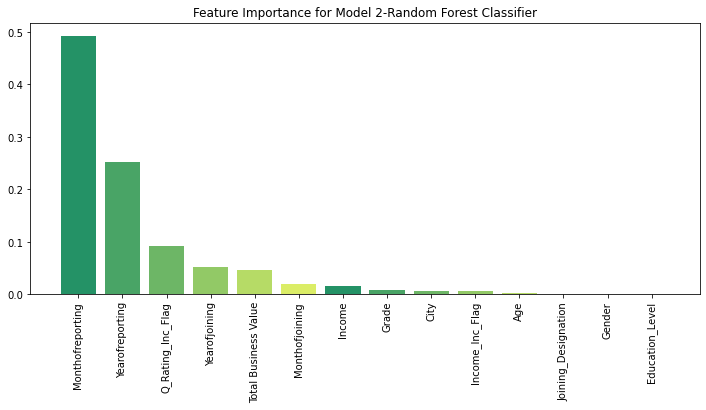

In [1250]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(12, 5)) # Create plot
plt.title("Feature Importance for Model 2-Random Forest Classifier") # Create plot title
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("summer")) # Add bars
plt.xticks(range(X_test.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() 

### Observations from Model 2- Random Forest Classifier (RF):

* Best parameters are : {'max_depth': 3, 'n_estimators': 50}, score is : 0.97
* Test Accuracy : 0.96
* f1_score : 0.97
* The recall score for predicting leaving the company is 0.96
* The precision score for predicting leaving the company is 0.98
* The AUC score for predicting leaving the company is 0.97
* Model Sensitivity:0.96
* Model Specificity:0.95
* Most important features(highest to lowest): 
    -Month Of Reporting
    -Year of Reporting
    -Quarterly performance increase
    -Year of Joining
    -Total Business Value.

#### Summary:
Model 2 with the random forest classifier has better AUC metric than model 1 Decision Tree Classifier.
Another very significant advantage is this RF model captures the feature importance more accurately.
The precision -recall curve is also better for the RF model.

### Model 3:  Gradient Boosted Decision Tree (GBDT) Classifier

* Based on powerful Gradient Boosting technique that offers multiple benefits over Random Forest classifiers such as-
- Runtime efficiency due to the iterative training and additive combination.
- Gives us the flexibility to use any differentiable loss function during training.

In [1286]:
from sklearn.ensemble import GradientBoostingClassifier as GBDT
params = {
        'learning_rate': [0.1,0.4, 0.6, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'max_depth': [3, 4, 5,6],
    'n_estimators':[50,100,150,200,250]
        }
model3=GBDT()


In [1287]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model3, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, cv=skf.split(X_train,Y_train), random_state=1001 )
# number of iterations=10, n_jobs=4= it will try to distribute it across 4 cores
start = dt.datetime.now()
random_search.fit(X_train, Y_train)
end = dt.datetime.now()

In [1288]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1}


#### Training GBDT on the best hyperparameters identified during StratifiedKFold cross validation

In [1289]:
best_gbdt = GBDT(subsample=0.6, n_estimators=150, max_depth= 6, learning_rate= 0.1)
best_gbdt.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=150, subsample=0.6)

In [1290]:
print(f"Time taken for training : {end - start}\nTraining accuracy:{best_gbdt.score(X_train, Y_train)}\nTest Accuracy:{best_gbdt.score(X_test, Y_test)}")

Time taken for training : 0:00:03.969224
Training accuracy:1.0
Test Accuracy:0.960167714884696


 Model 3: GBDT Performance Report


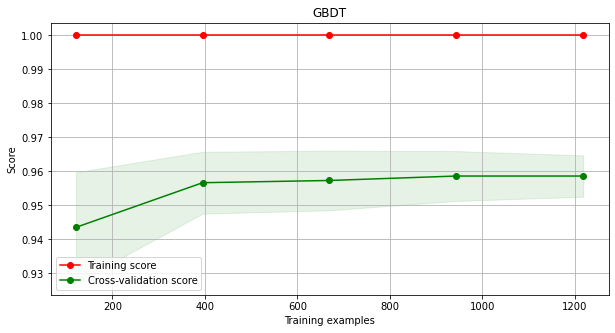

                                   precision    recall  f1-score   support

Not leaving the company (Churn:0)       0.93      0.94      0.94       150
    Leaving the company (Churn:1)       0.97      0.97      0.97       327

                         accuracy                           0.96       477
                        macro avg       0.95      0.95      0.95       477
                     weighted avg       0.96      0.96      0.96       477

Test Accuracy : 96.0167714884696%
recall_score : 96.94189602446484%
precision_score : 97.23926380368098%
f1_score : 97.09035222052069%
[[141   9]
 [ 10 317]]
Model 3: GBDT Sensitivity: 0.97
Model 3: GBDT Specificity: 0.94


In [1294]:
print(" Model 3: GBDT Performance Report")

# Predicting the Test set results
Y_pred = best_gbdt.predict(X_test)
plot_learning_curve(best_gbdt, X_train, Y_train, "GBDT")
print(f"{classification_report(Y_test, Y_pred, target_names=['Not leaving the company (Churn:0)','Leaving the company (Churn:1)'])}")
print(f"Test Accuracy : {accuracy_score(Y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(Y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(Y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(Y_test, Y_pred)*100}%")

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

confusion = confusion_matrix(Y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Calculate the sensitivity

print(f"Model 3: GBDT Sensitivity: {np.round((TP/(TP+FN)),2)}")
# Calculate the specificity

print(f"Model 3: GBDT Specificity: {np.round((TN/(TN+FP)),2)}")

AUC SCORE :0.9733537206931703


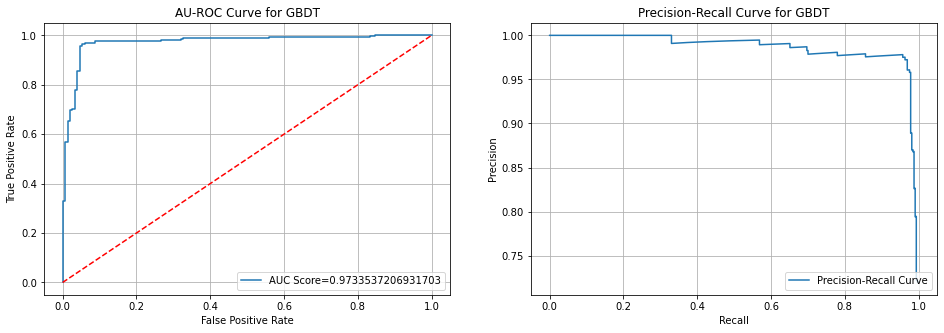

In [1292]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = best_gbdt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)

#Create ROC curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AU-ROC Curve for GBDT")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(Y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for GBDT")
plt.show()


### Feature Importance

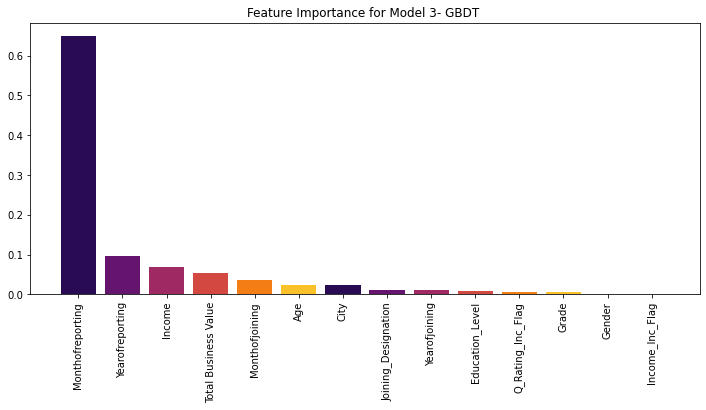

In [1295]:
importances =best_gbdt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(12, 5)) # Create plot
plt.title("Feature Importance for Model 3- GBDT ") # Create plot title
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("inferno")) # Add bars
plt.xticks(range(X_test.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() 

### Observations from Model 3-Gradient Boosted Decision Tree (GBDT) Classifier:

* Best hyperparameters:{'subsample': 0.6, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1}
* The AUC score for predicting leaving the company is 0.97.
* Test Accuracy : 0.96
* f1_score : 0.97
* The recall score for predicting leaving the company is 0.97 versus 0.96 for RF model.
* The precision score for predicting leaving the company is 0.97 which is slightly less than the RF model (0.97).
* Model Sensitivity:0.97 more than RF model(0.96)
* Model Specificity:0.94 slight less than RF model(0.95)
* Top most important features (Highest to lowest): 
    - Month Of Reporting
    - Year of Reporting
    - Income
    - Total Business Value
    - Month of Joining

#### Summary:
Model 3 with the GBDT classifier has better sensitivity but less specificity compared to Model 2 Random Forest Classifier. Slightly different order of feature importances is observed with GBDT.


### Model 4: XGBOOST Classifier

* XGBoost-Extreme Gradient Boosting Library combining both bagging and boosting techniques.
* Using f1_score as the data is imbalanced.
* Using n_jobs as 4 emaning no. of jobs running parallely on 4 cores.
* Hyper-parameter tuning with max_depth , learning_rate, subsample, colsample_bytree , n_estimators, and n_iter
* Using StratifiedKFold cross validation and hyperparamter search using RandomizedSearchCV.

In [1300]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold  #StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains 
#approximately the same percentage of samples of each target class as the complete set.Our dataset has balanced classes, so not useful.
import datetime as dt
params = {
        'learning_rate': [0.1, 0.4,0.6, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
    'n_estimators':[50,100,150,200,250]
        }
xgb = XGBClassifier() 

In [1301]:
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, cv=skf.split(X_train,Y_train), random_state=1001 )

# number of iterations=10, n_jobs=4= it will try to distribute it across 4 cores

start = dt.datetime.now()
random_search.fit(X_train, Y_train)
end = dt.datetime.now()

In [1302]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### Training the model on the complete data using the best hyperparameters

In [1304]:
best_xgb = XGBClassifier(n_estimators=50,subsample=0.8, max_depth=5, learning_rate=0.1, colsample_bytree=1.0)
best_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [1305]:
print(f"Time taken for training : {end - start}\nTraining accuracy:{best_xgb.score(X_train, Y_train)}\nTest Accuracy: {best_xgb.score(X_test, Y_test)}")

Time taken for training : 0:00:01.031392
Training accuracy:0.9678266579120157
Test Accuracy: 0.960167714884696


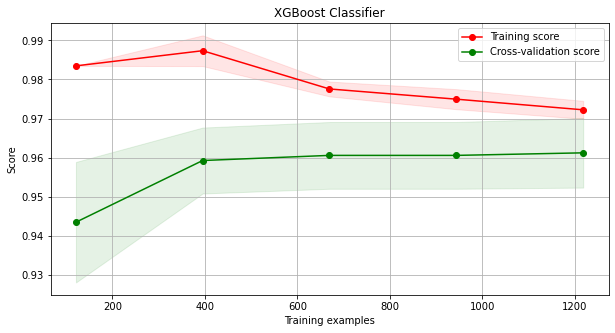

                                   precision    recall  f1-score   support

Not leaving the company (Churn:0)       0.93      0.94      0.94       150
    Leaving the company (Churn:1)       0.97      0.97      0.97       327

                         accuracy                           0.96       477
                        macro avg       0.95      0.95      0.95       477
                     weighted avg       0.96      0.96      0.96       477

Test Accuracy : 96.0167714884696%
recall_score : 96.94189602446484%
precision_score : 97.23926380368098%
f1_score : 97.09035222052069%
[[141   9]
 [ 10 317]]
Model 3: XGBoost Sensitivity: 0.97
Model 3: XGBoost Specificity: 0.94


In [1307]:
# Predicting the Test set results
Y_pred = best_xgb.predict(X_test)
plot_learning_curve(best_xgb, X_train, Y_train, "XGBoost Classifier")


print(f"{classification_report(Y_test, Y_pred, target_names=['Not leaving the company (Churn:0)','Leaving the company (Churn:1)'])}")
print(f"Test Accuracy : {accuracy_score(Y_test, Y_pred)*100}%")
print(f"recall_score : {recall_score(Y_test, Y_pred)*100}%")
print(f"precision_score : {precision_score(Y_test, Y_pred)*100}%")
print(f"f1_score : {f1_score(Y_test, Y_pred)*100}%")

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

confusion = confusion_matrix(Y_test, Y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculate the sensitivity
print(f"Model 3: XGBoost Sensitivity: {np.round((TP/(TP+FN)),2)}")

# Calculate the specificity
print(f"Model 3: XGBoost Specificity: {np.round((TN/(TN+FP)),2)}")

AUC SCORE :0.9807645259938835


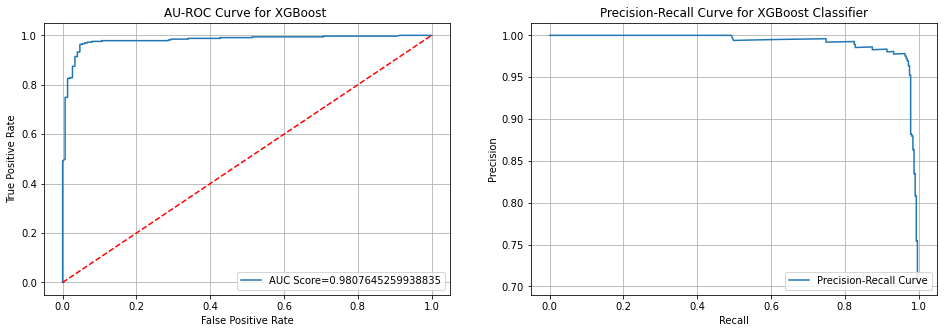

In [1308]:
# AUC- ROC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

Y_pred_proba = best_xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)

#Create ROC curve
fig, a = plt.subplots(1,2,squeeze=False,figsize=(16,5))
a[0][0].plot(fpr,tpr,label="AUC Score="+str(auc))
a[0][0].plot([0, 1], [0, 1],'r--')
a[0][0].set_ylabel('True Positive Rate')
a[0][0].set_xlabel('False Positive Rate')
a[0][0].legend(loc=4)
a[0][0].grid()
a[0][0].set_title("AU-ROC Curve for XGBoost ")
print(f"AUC SCORE :{auc}" )

# Precision Recall Curve
pre, re,_ = precision_recall_curve(Y_test, Y_pred_proba)
a[0][1].plot(re, pre, label='Precision-Recall Curve')
a[0][1].set_ylabel('Precision')
a[0][1].set_xlabel('Recall')
a[0][1].legend(loc=4)
a[0][1].grid()
a[0][1].set_title("Precision-Recall Curve for XGBoost Classifier")
plt.show()

### Feature Importances using XGBoost

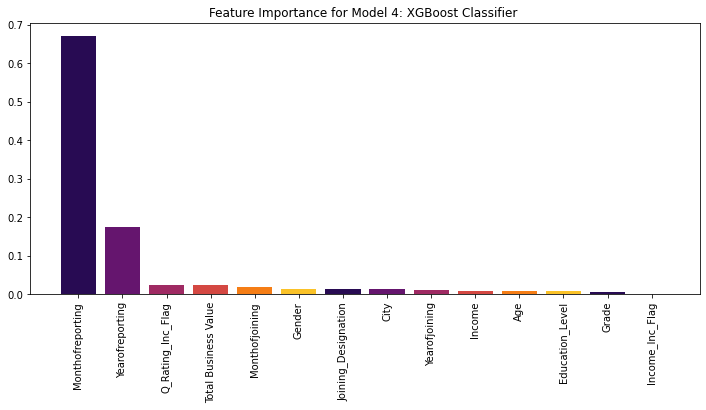

In [1310]:
importances =best_xgb.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(12, 5)) # Create plot
plt.title("Feature Importance for Model 4: XGBoost Classifier ") # Create plot title
plt.bar(range(X_test.shape[1]), importances[indices],color=sns.color_palette("inferno")) # Add bars
plt.xticks(range(X_test.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() 

### Observations from Model 4-XGBoost Classifier:

* XGBoost Best hyperparameters:{'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
* The AUC score for predicting leaving the company is 0.98, an improvement over the previous GBDT model with 0.97.
* Test Accuracy : 0.96
* recall_score :0.97
* precision_score : 0.9723
* f1_score : 0.97
* The recall score for predicting leaving the company is 0.97
* The precision score for predicting leaving the company is 0.97
* Model Sensitivity:0.97
* Model Specificity:0.94
* Top most important features:
    - Month Of Reporting
    - Year of Reporting
    - Quarterly performance increase
    - Total Business Value
    - Month of Joining


We obtained the best AUC score of 0.98 with the XGBoost model.

## Conclusion



It is a no-brainer that the cost of acquiring new drivers is at least 5X the cost of retention. In our analysis we evaluated four tree-based models and can rank them as follows based on their prediction performance metrics:


Model4 (XGBoost) > Model3 (GBDT) > Model2 (Random Forest) > Model1 (Decision Trees)

Using the feature importance insights generated from the models, some important predictors of driver attrition are -

•Month and Year of Reporting: Drivers who actively reported into the system every month were less likely to leave. Recommendation: Company should reward such drivers with points. Company can leverage gamification based motivation strategy where drivers rank up through different levels and accumulate points for continued consistency on the system.

•Quarterly Performance Rating Increase: Drivers with an increase in their quarterly rating were more likely to stay with the company. Recommendation: Company should identify the driver profile with low/high quarterly rating and extend loyalty programs that incentivizes performance improvements. Quarterly performance reviews and additional training could be imparted to the drivers whose rating has not increased over the last quarter so that issues can be identified with concerned drivers and attrition can be prevented.

•Total Business Value: This is an important feature in predicting if a driver is going to leave the company or not. Recommendation: The total business value is the total business that a driver generates, the company should set small financial milestones for the drivers to work through. The company should roll out a reward and recognition program for the drivers who meet their milestones.

•Income/Grade: Income plays an important role in predicting the driver attrition. Recommendation: Company should ensure that the drivers have enough opportunities and motivation to increase their monthly average income above a certain threshold. Another option to ease the financial burden on the drivers and increase their morale is to provide vehicle maintenance offers, insurance policies, health checkups, and special education programs etc.


In [1351]:
!jupyter nbconvert "RideShare_Driver_Attrition_Analysis" --to pdf

[NbConvertApp] Converting notebook RideShare_Driver_Attrition_Analysis.ipynb to pdf
[NbConvertApp] Support files will be in RideShare_Driver_Attrition_Analysis_files/
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_files
[NbConvertApp] Making directory ./RideShare_Driver_Attrition_Analysis_fil